# Capture and record city cameras automatically

---
### Import modules

In [3]:
from modules.cameras import cameras
from modules.recorder import recorder

import numpy as np
from apscheduler.schedulers.blocking import BlockingScheduler
from IPython.display import clear_output as co
import warnings; warnings.filterwarnings('ignore')

C:\Users\luisr\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


---
# Capture and record images from single camera

### Capture images from single camera

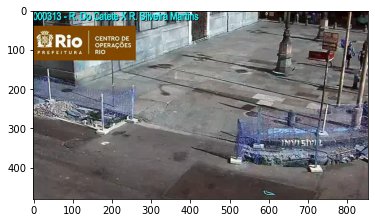

In [8]:
import matplotlib.pyplot as plt

frames = rec_normal.capture('313')

ax = plt.imshow(frames[0][1])

### Record images to google cloud storage

In [11]:
rec_normal = recorder(folder='test', n_frames=5, skip_invalid='histogram', max_invalid_frames=10)

rec_normal.record('1')

---

# Scheduled automatic recording for multiple cameras

### Set recording triggers

In [5]:
params_cam = [
    'acumulado_chuva_15_min - 1',
    'acumulado_chuva_15_min - 2',
    'acumulado_chuva_15_min - 3'
]

params_poly = [
    'label', 'waze_flood_status',
    'lâmina_status', 'bolsão_status', 'alagamento_status',
    'enchente_status', 'alagamento_enchente_status'
]

cams = cameras('mongo/Cameras AlertaRio', monitor=params_cam, logic='all')
poly_cams = cameras('mongo/gbf/Polygons', monitor=params_poly, logic='any', merge=True)
cams.report(); poly_cams.report(); print()

,In alert,Normality,Total
mongo/Cameras AlertaRio,0,2836,2850


,In alert,Normality,Total
mongo/gbf/Polygons,0,107,107


### Set recording parameters

In [6]:
freqs = {
    'normal': {'minute': '*/1'},
    'rain': {'minute': '*/15'},
    'flood': {'minute': '*/5'},
}

rec_normal = recorder(folder='normal', n_frames=5, skip_method='histogram', skip_max=10)
rec_rain = recorder(folder='rain', n_frames=15, skip_method='histogram', skip_max=10)
rec_flood = recorder(folder='flood', n_frames=15, skip_method='histogram', skip_max=10)

### Set recording schedule

In [ ]:
# ---
# Scheduler object and jobs

sched = BlockingScheduler()

# @sched.scheduled_job('cron', **freqs['normal'])
# def collect_normal_conditions():
#     cams.update(report=True); poly_cams.update(report=True); print()
#     codes = list(set(cams.normal).union(poly_cams.normal))
#     rec_normal.record_many(codes[:5], workers=100)
#     return

# @sched.scheduled_job('cron', **freqs['rain'])
# def collect_rain_conditions():
#     cams.update(report=True)
#     codes = np.random.permutation(cams.in_alert)
#     rec_rain.record_many(codes, workers=100)
#     return

@sched.scheduled_job('cron', **freqs['flood'])
def collect_flood_conditions():
    poly_cams.update(report=True); print()
    rec_flood.record_many(poly_cams.in_alert)
    return

### Start and monitor scheduled automatic recording

In [ ]:
sched.start()